In [1]:
import h5py
import numpy as np
import pylab as plt
from tqdm import tqdm
from astropy.io import fits
from astropy.stats import mad_std
from astroNN.apogee import allstar
from astroNN.shared import pylab_style
from astroNN.models import load_folder
import time 
from py.dataset_utils import APOKASC
from py.utils import powerspec_log_rebin_v2, numax_to_deltanu

pylab_style(paper=True)
spec_size = 7514

apokasc_f = APOKASC()
freq_range = apokasc_f.get_powerspec_freqrange()
all_psd = apokasc_f.get_smoothed_flattened_powerspec()
freq_range, all_psd = powerspec_log_rebin_v2(freq_range, all_psd)

all_psd = np.log(all_psd)
contspec = apokasc_f.get_contspec()
contspec[contspec>2.] = 1.

psd_training = np.array(all_psd)
spec_training = np.array(contspec)

nn_output_internal = psd_training.shape[1] // 4
psd_training = psd_training[:, :nn_output_internal*4]
freq_range = freq_range[:nn_output_internal*4]
print("Number of APOGEE-Kepler pairs: ", len(psd_training))
print("Power Spectra pixel number: ", psd_training.shape[1])

model = load_folder("./models/astroNN_VEncoderDecoder")

recont = model.predict(spec_training)
z_mean, z_stdev, z = model.predict_encoder(spec_training)

Number of APOGEE-Kepler pairs:  9869
Power Spectra pixel number:  2092
Loaded astroNN model, model type: Convolutional Variational Autoencoder -> ApokascEncoderDecoder


Prediction progress: 100%|██████████| 9869/9869 [00:00<00:00, 19884.80sample/s]


Number of data point for training:  2000


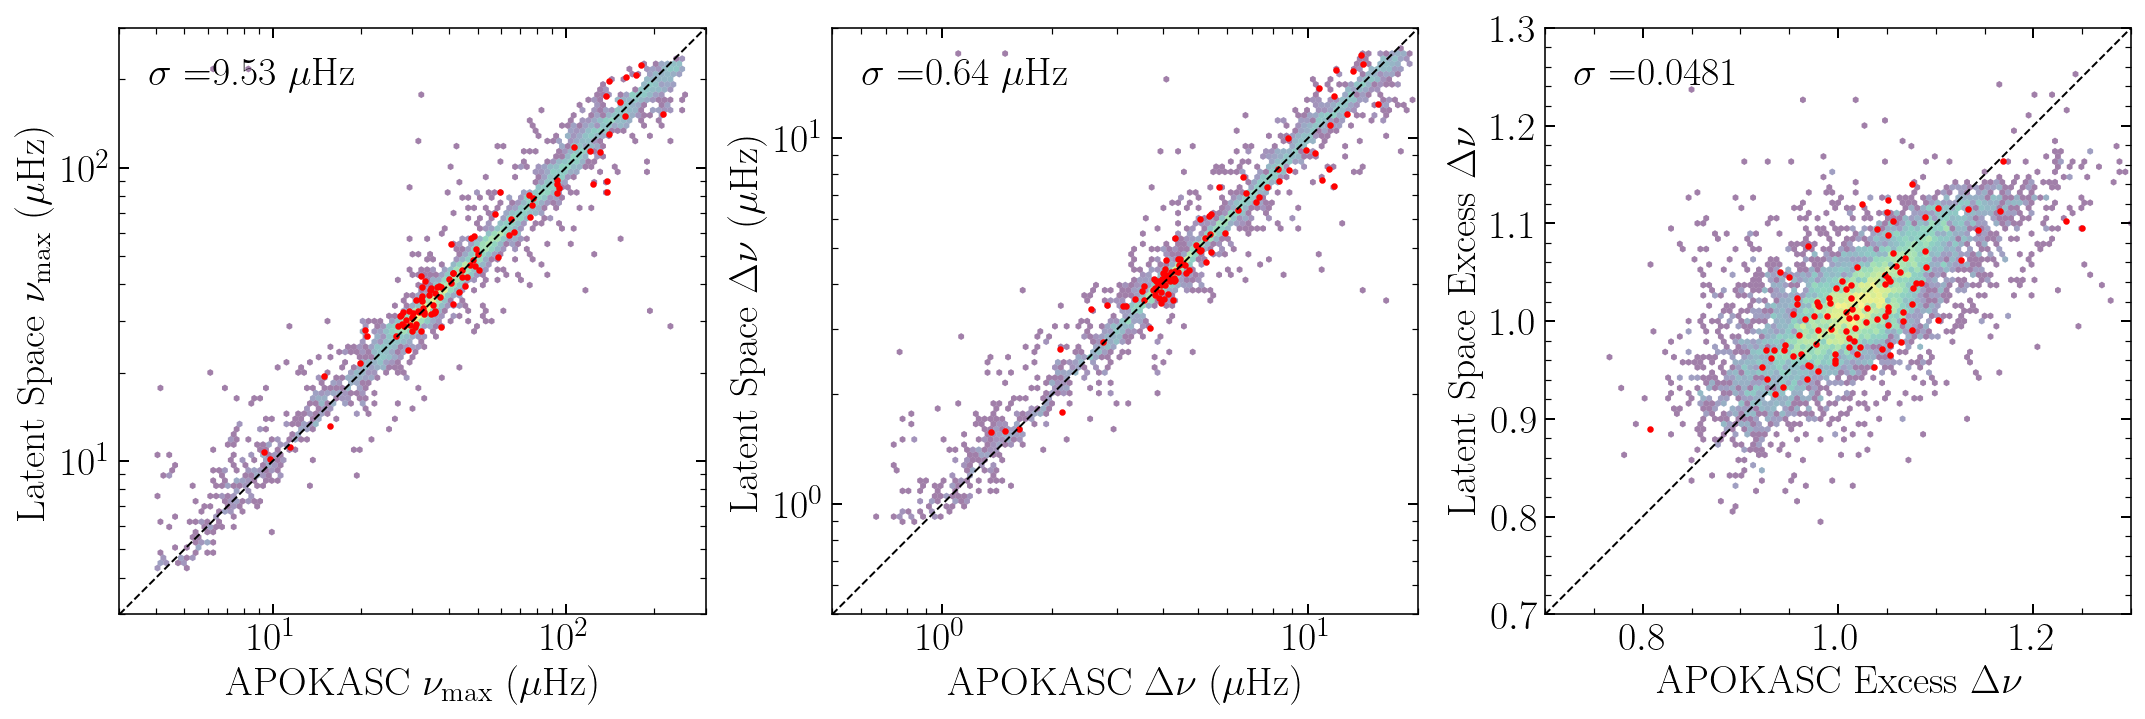

In [2]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from py.ensemble import ProbabilisticRandomForestRegressor
from astroNN.gaia import mag_to_absmag
from py.dataset_utils import stack_label

fit_func = lambda: ProbabilisticRandomForestRegressor()

good_idx = np.random.choice(list(range(len(z_mean))), size=2000, replace=False)
bad_idx = np.ones(len(z_mean), dtype=bool)
bad_idx[good_idx] = False
stacked_z_mean = z_mean
stacked_z_stdev = z_stdev

numax = apokasc_f.dataset["Numax"][()]
numax_error = apokasc_f.dataset["Numax_error"][()]
deltanu = apokasc_f.dataset["Dnu"][()]
deltanu_error = apokasc_f.dataset["Dnu_error"][()]
deltanu_expetation, deltanu_expetation_err = numax_to_deltanu(
    numax, numax_error, pipeline="syd"
)

print("Number of data point for training: ", len(good_idx))

regr = fit_func()
regr.fit(
    stacked_z_mean[good_idx],
    numax[good_idx],
    Xerr=stacked_z_stdev[good_idx],
    yerr=numax_error[good_idx],
)

numax_pred_all = np.mean(regr.predict(stacked_z_mean), axis=-1)
numax_pred = numax_pred_all[bad_idx]

regr2 = fit_func()
regr2.fit(
    stacked_z_mean[good_idx],
    deltanu[good_idx],
    Xerr=stacked_z_stdev[good_idx],
    yerr=deltanu_error[good_idx],
)
deltanu_pred_all = np.mean(regr2.predict(stacked_z_mean), axis=-1)
deltanu_pred = deltanu_pred_all[bad_idx]

excessnu = deltanu / deltanu_expetation
excessnu_pred_all = deltanu_pred_all / numax_to_deltanu(numax_pred_all)
excessnu_pred = excessnu_pred_all[bad_idx]

regr3 = fit_func()
all_stacked_z_mean = stack_label(
    stacked_z_mean,
    apokasc_f.allstar["TEFF"].filled(-9999.0),
    apokasc_f.allstar["FE_H"].filled(-9999.0),
)

all_stacked_z_stdev = stack_label(
    z_stdev,
    apokasc_f.allstar["TEFF_ERR"].filled(-9999.0),
    apokasc_f.allstar["FE_H_ERR"].filled(-9999.0),
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# ax1.scatter(apokasc_f.dataset["APOKASC3P_NU_MAX"][bad_idx], numax_pred, s=1)
ax1.hexbin(
    numax[bad_idx],
    numax_pred,
    bins="log",
    xscale="log",
    yscale="log",
    extent=np.log10([3.0, 300, 3.0, 300]),
    lw=0,
    alpha=0.5,
    rasterized=True,
)
ax1.scatter(numax[:100], numax_pred_all[:100], s=5, rasterized=True, c="r")
ax1.plot([3.0, 300], [3.0, 300], ls="--", c="k")
ax1.set_xlim(3.0, 300)
ax1.set_ylim(3.0, 300)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.text(
    0.05,
    0.95,
    f"$\sigma=${np.std(numax[bad_idx]-numax_pred):.2f} $\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.set_xlabel("APOKASC $\\nu_{\mathrm{max}}$ ($\mu$Hz)")
ax1.set_ylabel("Latent Space $\\nu_{\mathrm{max}}$ ($\mu$Hz)")


# ax2.scatter(apokasc_f.dataset["APOKASC3P_DELTA_NU"][bad_idx], deltanu_pred, s=1)
ax2.hexbin(
    deltanu[bad_idx],
    deltanu_pred,
    bins="log",
    xscale="log",
    yscale="log",
    extent=np.log10([0.5, 20, 0.5, 20]),
    lw=0,
    alpha=0.5,
    rasterized=True,
)
ax2.scatter(
    deltanu[:100],
    deltanu_pred_all[:100],
    s=5,
    rasterized=True,
    c="r",
)
ax2.plot([0.5, 20], [0.5, 20], ls="--", c="k")
ax2.set_xlim(0.5, 20)
ax2.set_ylim(0.5, 20)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.text(
    0.05,
    0.95,
    f"$\sigma=${np.std(deltanu[bad_idx]-deltanu_pred):.2f} $\mu$Hz",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax2.transAxes,
)
ax2.set_xlabel("APOKASC $\Delta \\nu$ ($\mu$Hz)")
ax2.set_ylabel("Latent Space $\Delta \\nu$ ($\mu$Hz)")

# ax3.scatter(excessnu[bad_idx], excessnu_pred, s=1)
ax3.hexbin(
    excessnu[bad_idx],
    excessnu_pred,
    bins="log",
    extent=[0.7, 1.3, 0.7, 1.3],
    lw=0,
    alpha=0.5,
    rasterized=True,
)
ax3.scatter(excessnu[:100], excessnu_pred_all[:100], s=5, rasterized=True, c="r")
ax3.plot([0.7, 1.3], [0.7, 1.3], ls="--", c="k")
ax3.set_xlim(0.7, 1.3)
ax3.set_ylim(0.7, 1.3)
ax3.text(
    0.05,
    0.95,
    f"$\sigma=${np.std(excessnu[bad_idx]-excessnu_pred):.4f}",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax3.transAxes,
)
ax3.set_xlabel("APOKASC Excess $\Delta \\nu$")
ax3.set_ylabel("Latent Space Excess $\Delta \\nu$")
fig.tight_layout()
fig.savefig("figs/seismic_test.pdf")

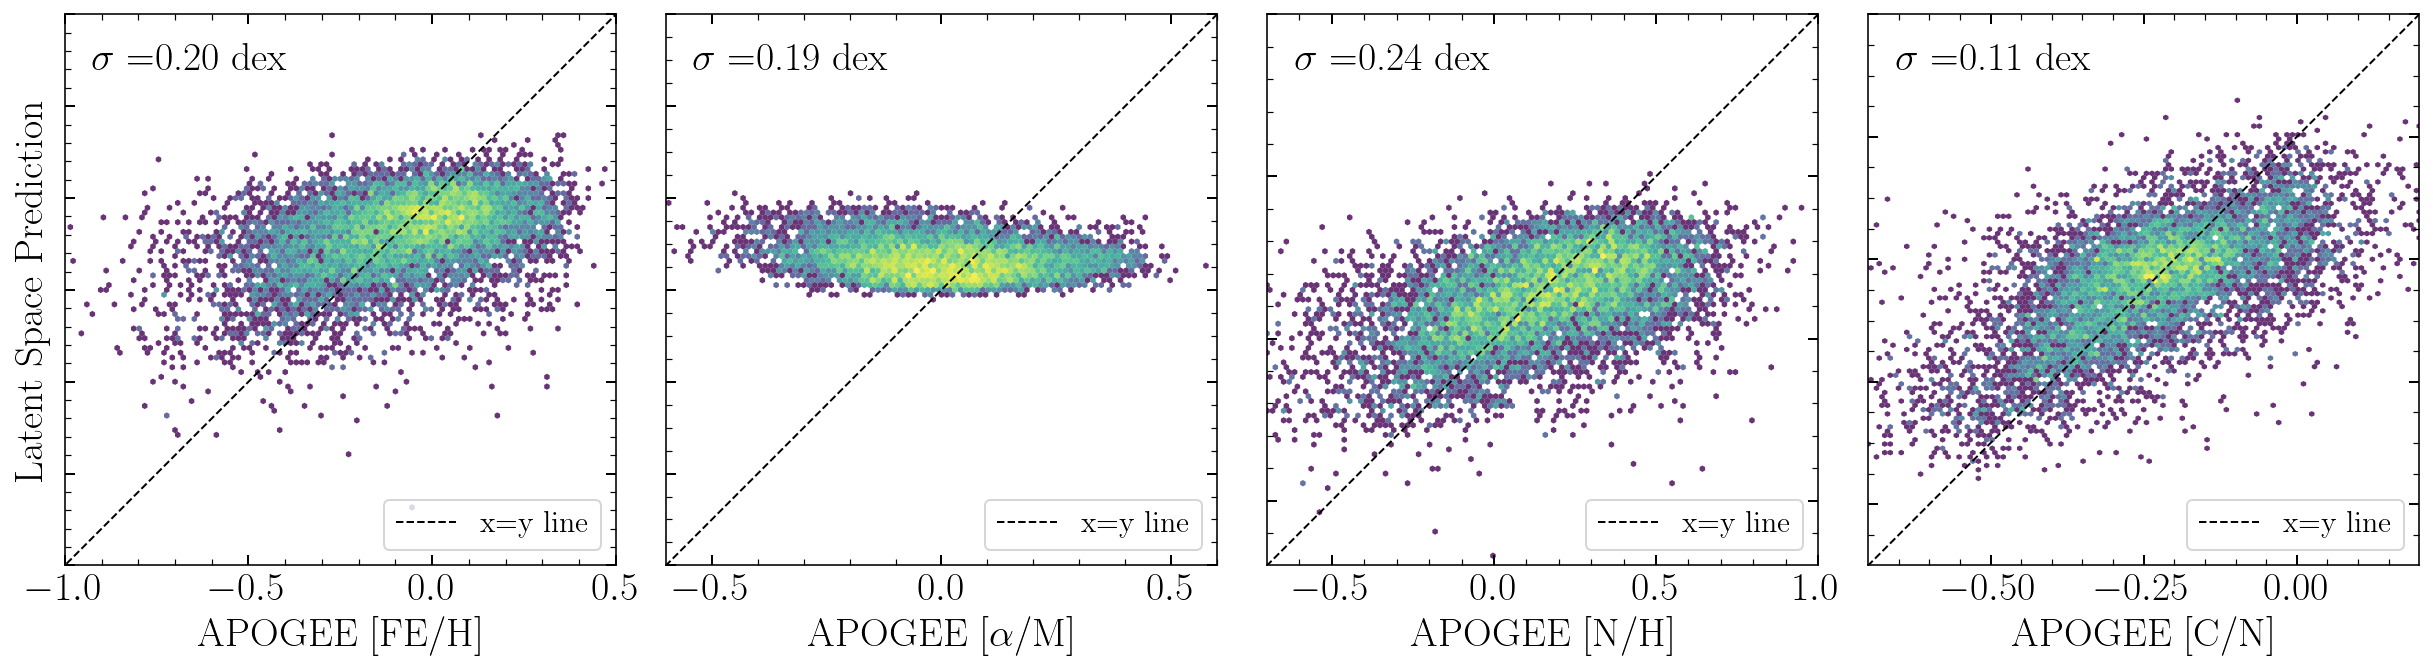

In [7]:
fit_func = lambda: RandomForestRegressor()

good_good_idx = (
    ~np.isnan(apokasc_f.allstar["TEFF"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["LOGG"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["FE_H"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["ALPHA_M"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["X_H"][:, 0].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["X_H"][:, 2].filled(np.nan))
)[good_idx]

regr4 = fit_func()
aspcap_labels = np.stack(
    [
        apokasc_f.allstar["TEFF"].filled(np.nan),
        apokasc_f.allstar["LOGG"].filled(np.nan),
        apokasc_f.allstar["FE_H"].filled(np.nan),
        apokasc_f.allstar["ALPHA_M"].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 2].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 0].filled(np.nan)
        - apokasc_f.allstar["X_H"][:, 2].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 0].filled(np.nan),
    ]
).T
regr4.fit(
    stacked_z_mean[good_idx][good_good_idx], aspcap_labels[good_idx][good_good_idx]
)
cn_pred = regr4.predict(stacked_z_mean[bad_idx])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17, 5))
ax1.hexbin(
    apokasc_f.allstar["FE_H"][bad_idx],
    cn_pred[:, 2],
    bins="log",
    extent=[-1.0, 0.5, -1.0, 0.5],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax1.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax1.set_xlim(-1.0, 0.5)
ax1.set_ylim(-1.0, 0.5)
ax1.set_yticklabels([])
ax1.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(apokasc_f.allstar['FE_H'][bad_idx] - cn_pred[:, 2]):.2f} dex",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.set_aspect("equal")
ax1.set_xlabel("APOGEE [FE/H]")
ax1.set_ylabel("Latent Space Prediction")
ax1.legend(loc="lower right")

ax2.hexbin(
    apokasc_f.allstar["X_H"][:, 5][bad_idx],
    cn_pred[:, 3],
    bins="log",
    extent=[-0.6, 0.6, -0.6, 0.6],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax2.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax2.set_xlim(-0.6, 0.6)
ax2.set_ylim(-0.6, 0.6)
ax2.set_yticklabels([])
ax2.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(apokasc_f.allstar['X_H'][:, 5][bad_idx] - cn_pred[:, 3]):.2f} dex",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax2.transAxes,
)
ax2.set_aspect("equal")
ax2.set_xlabel("APOGEE [$\\alpha$/M]")
ax2.legend(loc="lower right")

ax3.hexbin(
    apokasc_f.allstar["X_H"][:, 2][bad_idx],
    cn_pred[:, 4],
    bins="log",
    extent=[-0.7, 1.0, -0.7, 1.0],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax3.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax3.set_xlim(-0.7, 1.0)
ax3.set_ylim(-0.7, 1.0)
ax3.set_yticklabels([])
ax3.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(apokasc_f.allstar['X_H'][:, 2][bad_idx] - cn_pred[:, 4]):.2f} dex",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax3.transAxes,
)
ax3.set_aspect("equal")
ax3.set_xlabel("APOGEE [N/H]")
ax3.legend(loc="lower right")

ax4.hexbin(
    (apokasc_f.allstar["X_H"][:, 0] - apokasc_f.allstar["X_H"][:, 2])[bad_idx],
    cn_pred[:, 5],
    bins="log",
    extent=[-0.7, 0.2, -0.6, 0.2],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax4.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax4.set_xlim(-0.7, 0.2)
ax4.set_ylim(-0.7, 0.2)
ax4.set_yticklabels([])
ax4.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std((apokasc_f.allstar['X_H'][:, 0] - apokasc_f.allstar['X_H'][:, 2])[bad_idx] - cn_pred[:, 5]):.2f} dex",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax4.transAxes,
)
ax4.set_aspect("equal")
ax4.set_xlabel("APOGEE [C/N]")
ax4.legend(loc="lower right")
fig.tight_layout()
fig.savefig("./figs/latent_aspcap.pdf")

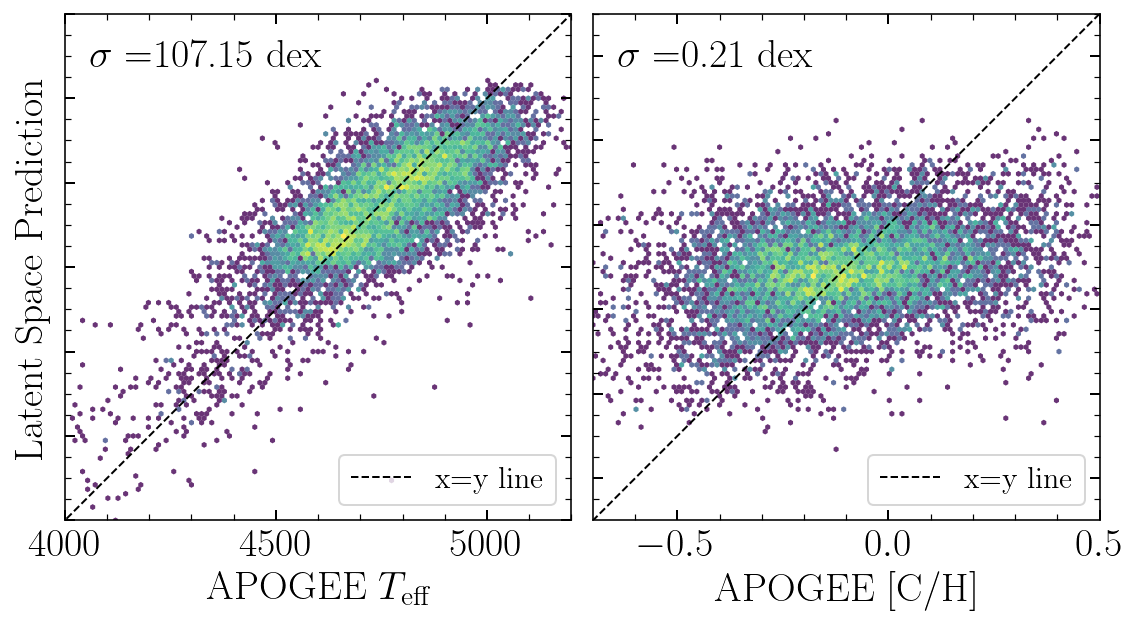

In [4]:
fit_func = lambda: RandomForestRegressor()

good_good_idx = (
    ~np.isnan(apokasc_f.allstar["TEFF"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["LOGG"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["FE_H"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["ALPHA_M"].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["X_H"][:, 0].filled(np.nan))
    & ~np.isnan(apokasc_f.allstar["X_H"][:, 2].filled(np.nan))
)[good_idx]

regr4 = fit_func()
aspcap_labels = np.stack(
    [
        apokasc_f.allstar["TEFF"].filled(np.nan),
        apokasc_f.allstar["LOGG"].filled(np.nan),
        apokasc_f.allstar["FE_H"].filled(np.nan),
        apokasc_f.allstar["ALPHA_M"].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 2].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 0].filled(np.nan)
        - apokasc_f.allstar["X_H"][:, 2].filled(np.nan),
        apokasc_f.allstar["X_H"][:, 0].filled(np.nan),
    ]
).T
regr4.fit(
    stacked_z_mean[good_idx][good_good_idx], aspcap_labels[good_idx][good_good_idx]
)
cn_pred = regr4.predict(stacked_z_mean[bad_idx])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
ax1.hexbin(
    apokasc_f.allstar["TEFF"][bad_idx],
    cn_pred[:, 0],
    bins="log",
    extent=[4000, 5200, 4000, 5200],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax1.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax1.set_xlim(4000, 5200)
ax1.set_ylim(4000, 5200)
ax1.set_yticklabels([])
ax1.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(apokasc_f.allstar['TEFF'][bad_idx] - cn_pred[:, 0]):.2f} K",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.set_aspect("equal")
ax1.set_xlabel("APOGEE $T_\mathrm{eff}$")
ax1.set_ylabel("Latent Space Prediction")
ax1.legend(loc="lower right")

ax2.hexbin(
    apokasc_f.allstar["X_H"][:, 0][bad_idx],
    cn_pred[:, 6],
    bins="log",
    extent=[-0.7, 0.5, -0.7, 0.5],
    lw=0,
    alpha=0.8,
    rasterized=True,
)
ax2.plot([-9999, 9999], [-9999, 9999], ls="--", c="k", label="x=y line")
ax2.set_xlim(-0.7, 0.5)
ax2.set_ylim(-0.7, 0.5)
ax2.set_yticklabels([])
ax2.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(apokasc_f.allstar['X_H'][:, 0][bad_idx] - cn_pred[:, 6]):.2f} dex",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax2.transAxes,
)
ax2.set_aspect("equal")
ax2.set_xlabel("APOGEE [C/H]")
ax2.legend(loc="lower right")

fig.tight_layout()

In [8]:
from scipy.optimize import curve_fit
rgb_idx = apokasc_f.dataset["Evostate"] == 1
popt, pcov = curve_fit(lambda x, a, b: a*x+b, apokasc_f.allstar["LOGG"][~rgb_idx], apokasc_f.allstar["TEFF"][~rgb_idx])
print(mad_std(popt[0]*apokasc_f.allstar["LOGG"][~rgb_idx]+ popt[1] - apokasc_f.allstar["TEFF"][~rgb_idx]))
print("Latent Space Teff only slightly better than predicting Teff from logg")

115.77291791561555
Latent Space Teff only slightly better than predicting Teff from logg


c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Number of training point:  1287


C:\Users\Henry\AppData\Local\Temp\ipykernel_18500\826850207.py:45: RuntimeWarning: divide by zero encountered in divide
C:\Users\Henry\AppData\Local\Temp\ipykernel_18500\826850207.py:59: RuntimeWarning: divide by zero encountered in divide


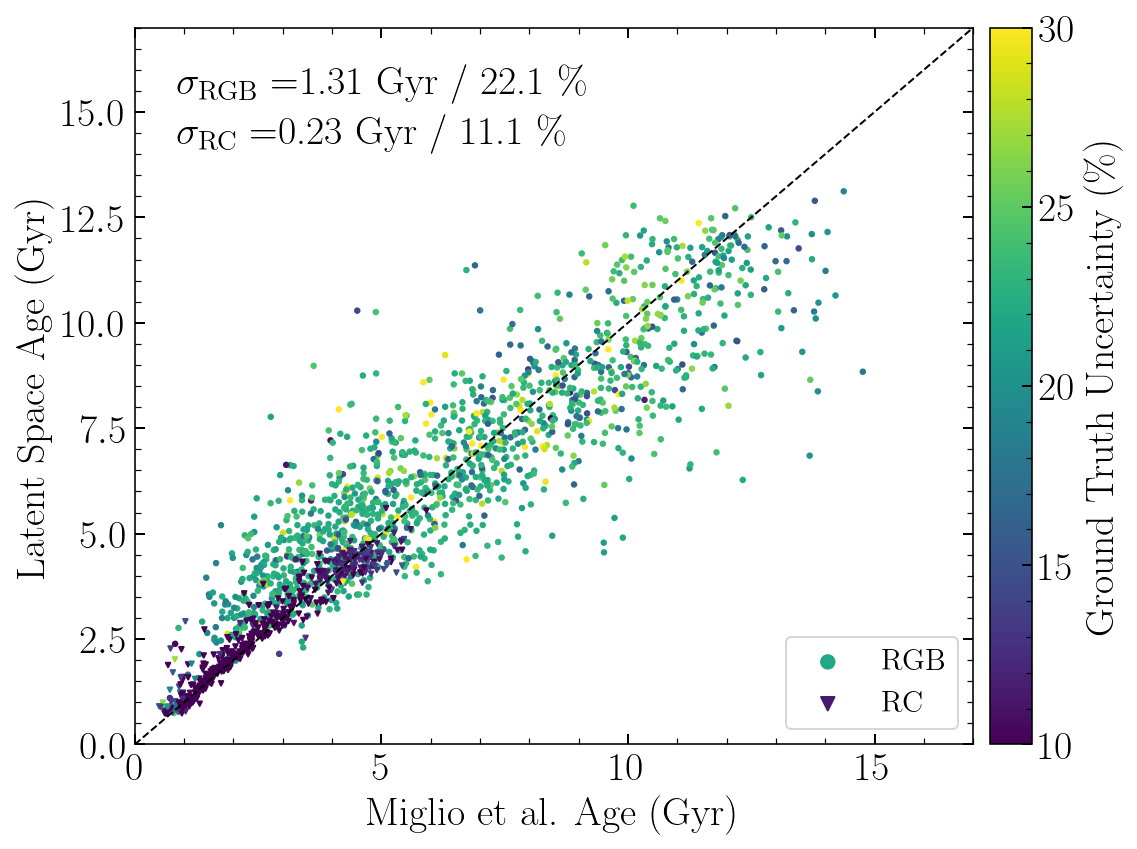

In [4]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from py.ensemble import ProbabilisticRandomForestRegressor

# np.random.seed(seed=1)

age_training_name = "Miglio_LogAge"
# not actually 4000, see the code below. Only usng ~1200 stars as training depending on your luck
good_idx = np.random.choice(list(range(len(z_mean))), size=4000, replace=False)
bad_idx = np.ones(len(z_mean), dtype=bool)
bad_idx[good_idx] = False

regr6 = ProbabilisticRandomForestRegressor()
# good_good_idx = ((apokasc_f.dataset["APOKASC2_AGE"][good_idx] > 0.) & (apokasc_f.dataset["APOKASC2_EVSTATES"][good_idx] == "RGB"))
good_good_idx = (apokasc_f.dataset[age_training_name][good_idx] != -9999.) & (
    apokasc_f.dataset["Evostate"][good_idx] > 0
)
print("Number of training point: ", np.sum(good_good_idx))

regr6.fit(
    all_stacked_z_mean[good_idx][good_good_idx],
    np.atleast_2d(apokasc_f.dataset[age_training_name][good_idx][good_good_idx]).T,
    Xerr=all_stacked_z_stdev[good_idx][good_good_idx],
    yerr=np.atleast_2d(
        apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx]
    ).T,
    sample_weight=1.0 / apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx] ** 2
)

# bad_good_idx = ((apokasc_f.dataset["APOKASC2_AGE"][bad_idx] > 0.) & (apokasc_f.dataset["APOKASC2_EVSTATES"][bad_idx] == "RGB"))
bad_good_idx = (apokasc_f.dataset[age_training_name][bad_idx] != -9999.) & (
    apokasc_f.dataset["Evostate"][bad_idx] > 0
)
age_pred = 10 ** regr6.predict(all_stacked_z_mean[bad_idx][bad_good_idx])
age_pred_stddev = mad_std(age_pred, axis=(-1))
age_pred = np.mean(age_pred, axis=(-1))
rgb_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 1
rc_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 2

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.scatter(
    10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rgb_idx],
    age_pred[rgb_idx],
    s=5,
    c=(
        apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
    )[bad_idx][bad_good_idx][rgb_idx]
    * 100,
    vmin=10,
    vmax=30,
    cmap="viridis",
    rasterized=True,
    label="RGB",
)
mappable = ax1.scatter(
    10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rc_idx],
    age_pred[rc_idx],
    s=5,
    c=(
        apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
    )[bad_idx][bad_good_idx][rc_idx]
    * 100,
    vmin=10,
    vmax=30,
    marker="v",
    cmap="viridis",
    rasterized=True,
    label="RC",
)
ax1.plot([0.0, 20.0], [0.0, 20], ls="--", c="k")
ax1.set_xlim(0.0, 17.0)
ax1.set_ylim(0.0, 17.0)
ax1.text(
    0.05,
    0.95,
    f"$\sigma_{{\mathrm{{RGB}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rgb_idx]):.2f} Gyr /"
    + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rgb_idx])*100:.1f} \%",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.text(
    0.05,
    0.88,
    f"$\sigma_{{\mathrm{{RC}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rc_idx]):.2f} Gyr /"
    + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rc_idx])*100:.1f} \%",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.legend(loc="lower right")
ax1.set_xlabel("Miglio et al. Age (Gyr)")
ax1.set_ylabel("Latent Space Age (Gyr)")

ax_divider = make_axes_locatable(ax1)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cbar = plt.colorbar(mappable, cax=cax, ticks=[10, 15, 20, 25, 30])
cbar.set_label("Ground Truth Uncertainty (\%)")

fig.tight_layout()
fig.savefig("./figs/age_test.pdf")

In [5]:
regr6.save_model("./models/astroNN_VEncoderDecoder/latent_age_model")

160 272
Finished all gradient calculation, 0.64 seconds elapsed
Finished all gradient calculation, 0.24 seconds elapsed


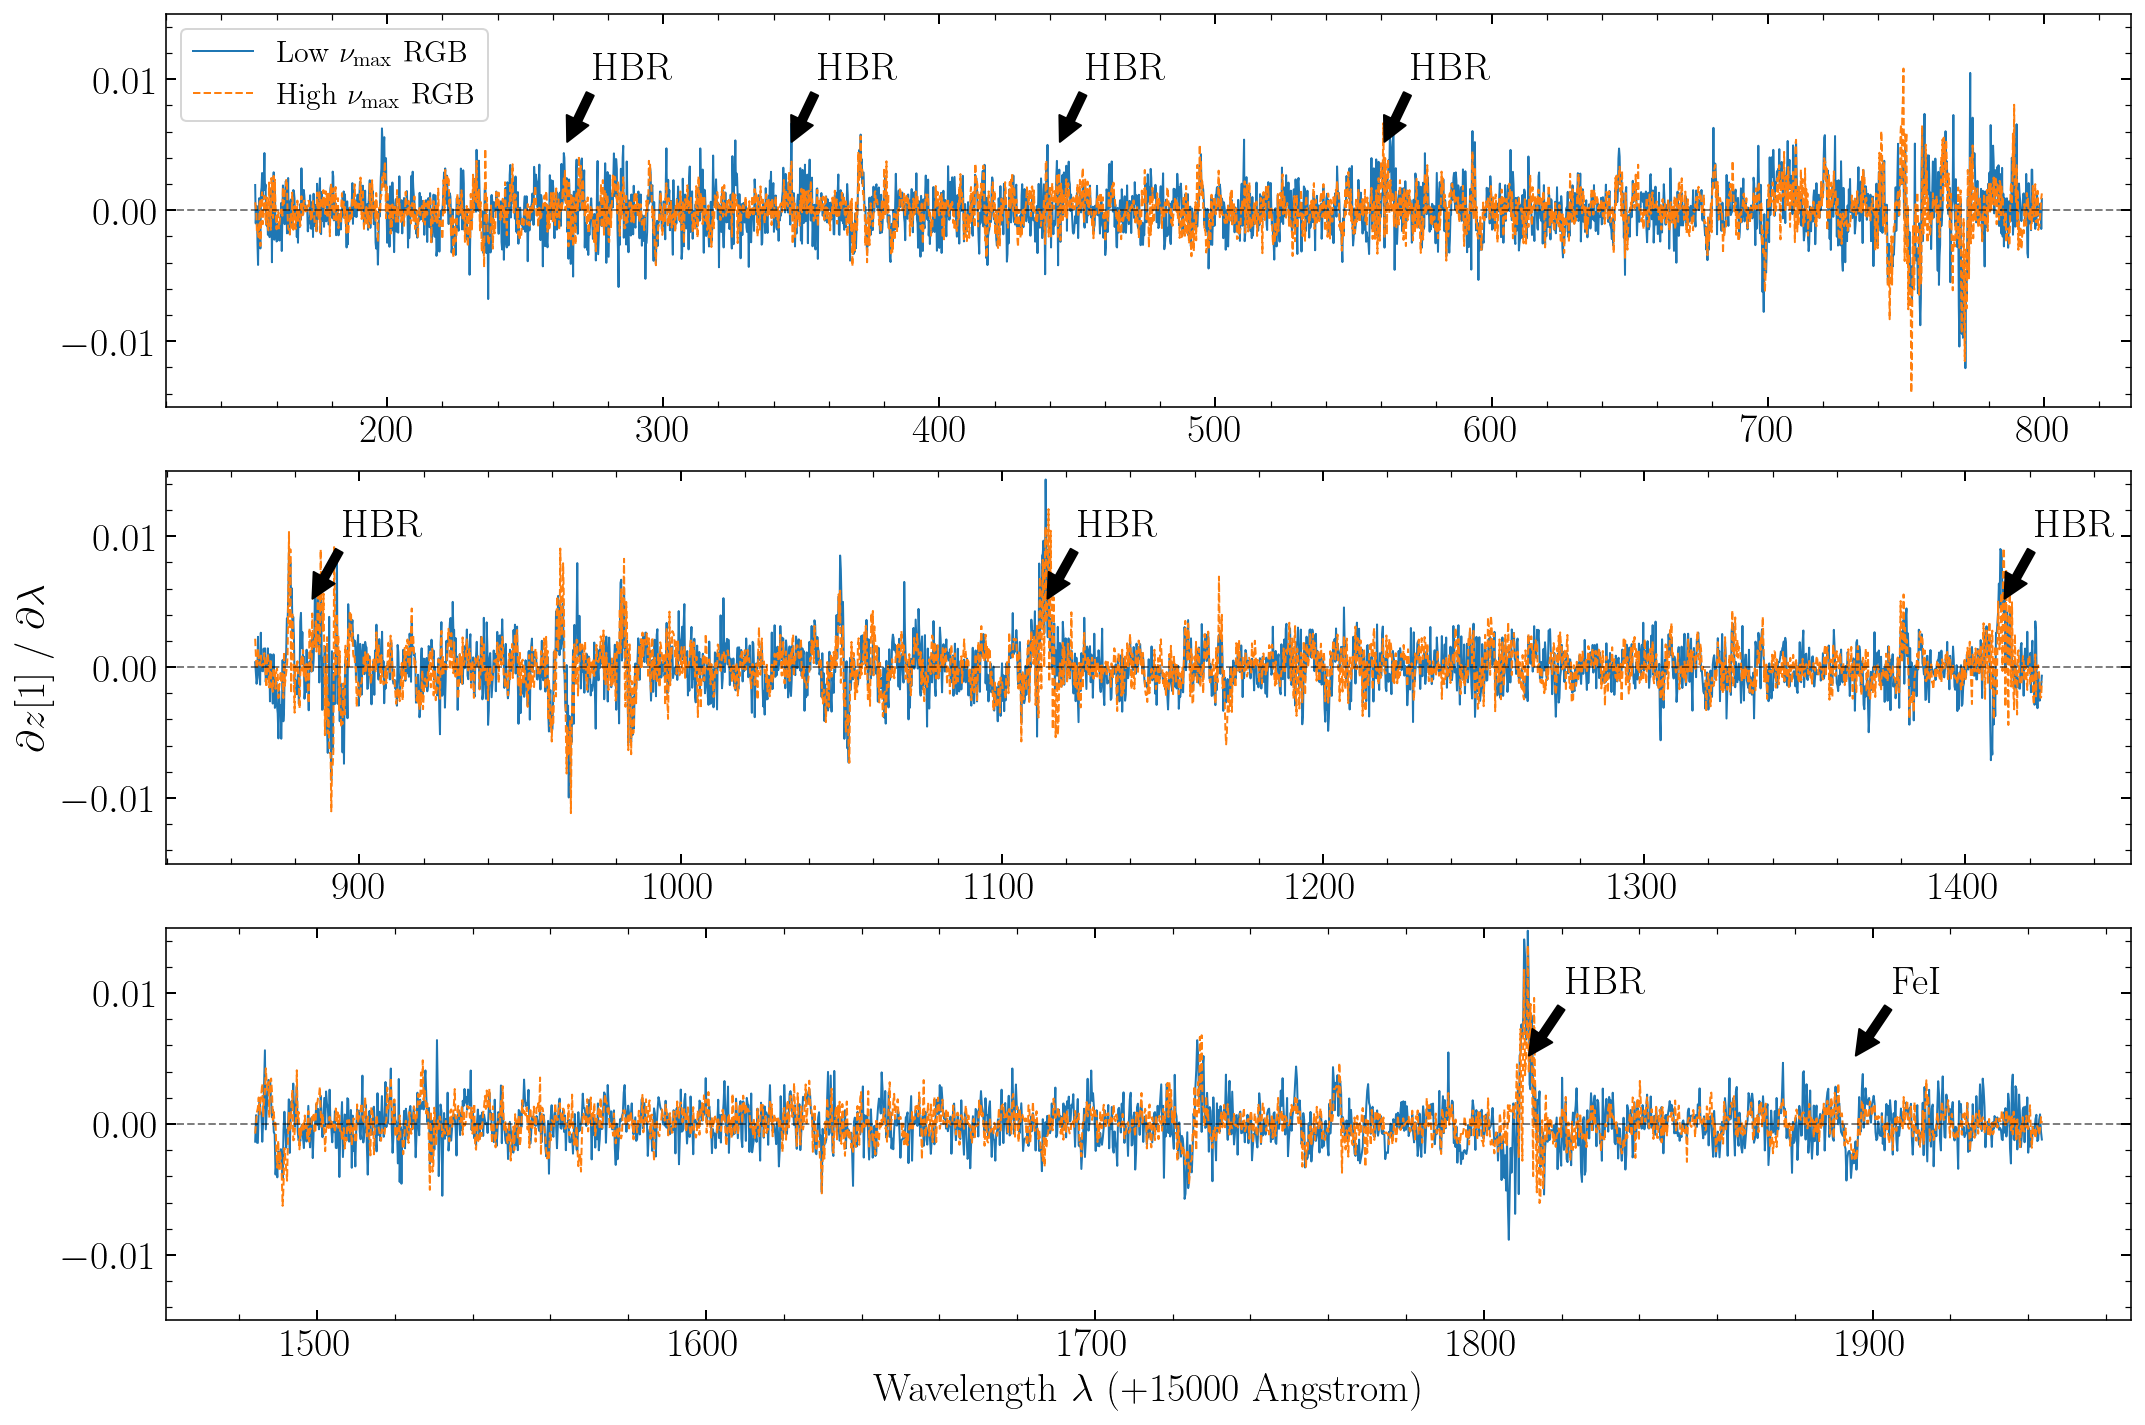

In [14]:
# define HBR lines for plotting
HBR_blue_lines = np.array([15264.717, 15345.992, 15443.148, 15560.708]) - 15000.0
HBR_green_lines = np.array([15884.888, 16113.721, 16411.681]) - 15000.0
HBR_red_lines = np.array([16811.117]) - 15000.0

low_numax_idx = (numax > 15.0) & (numax < 20.0)
high_numax_idx = (numax > 180.0) & (numax < 220.0)

print(np.sum(low_numax_idx), np.sum(high_numax_idx))

z_idx = 1

low_rgb_jac = np.mean(
    model.jacobian_latent(spec_training[low_numax_idx])[:, z_idx], axis=0
)
high_rgb_jac = np.mean(
    model.jacobian_latent(spec_training[high_numax_idx])[:, z_idx], axis=0
)

from astroNN.apogee.chips import wavelength_solution, chips_split

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=17)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

target_name = f"z[{z_idx}]"

fig = plt.figure(figsize=(15, 10))
low_numax_jac_b, low_numax_jac_g, low_numax_jac_r = chips_split(low_rgb_jac, dr=17)
high_numax_jac_b, high_numax_jac_g, high_numax_jac_r = chips_split(high_rgb_jac, dr=17)


# fig.suptitle(f'Gradient of ${target_name}$ in Metal Poor and Rich Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(
    lambda_blue, low_numax_jac_b[0], linewidth=1, label="Low $\\nu_{\mathrm{max}}$ RGB"
)
ax1.plot(
    lambda_blue,
    high_numax_jac_b[0],
    linewidth=1,
    ls="--",
    label="High $\\nu_{\mathrm{max}}$ RGB",
)
ax1.set_ylim(-0.015, 0.015)

ax2 = fig.add_subplot(312)
ax2.set_ylabel(
    r"$\partial$" + f"${target_name}$" + " / " + r"$\partial\lambda$", fontsize=20
)
ax2.plot(
    lambda_green, low_numax_jac_g[0], linewidth=1, label="Low $\\nu_{\mathrm{max}}$ RGB"
)
ax2.plot(
    lambda_green,
    high_numax_jac_g[0],
    linewidth=1,
    ls="--",
    label="High $\\nu_{\mathrm{max}}$ RGB",
)
ax2.set_ylim(-0.015, 0.015)

ax3 = fig.add_subplot(313)
ax3.plot(
    lambda_red, low_numax_jac_r[0], linewidth=1, label="Low $\\nu_{\mathrm{max}}$ RGB"
)
ax3.plot(
    lambda_red,
    high_numax_jac_r[0],
    linewidth=1,
    ls="--",
    label="High $\\nu_{\mathrm{max}}$ RGB",
)
ax3.set_ylim(-0.015, 0.015)

leg = ax1.legend(loc="best", fontsize=15)
ax3.set_xlabel(r"Wavelength $\lambda$ (+15000 Angstrom)", fontsize=20)

ax1.axhline(0, ls="--", c="k", lw=1, alpha=0.5)
ax2.axhline(0, ls="--", c="k", lw=1, alpha=0.5)
ax3.axhline(0, ls="--", c="k", lw=1, alpha=0.5)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(3.0)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate(
        "HBR",
        xy=(HBR_blue_line, 0.005),
        xytext=(HBR_blue_line + 10, 0.01),
        arrowprops=dict(facecolor="black", shrink=0.05),
        fontsize=20,
    )

for HBR_green_line in HBR_green_lines:
    ax2.annotate(
        "HBR",
        xy=(HBR_green_line, 0.005),
        xytext=(HBR_green_line + 10, 0.01),
        arrowprops=dict(facecolor="black", shrink=0.05),
        fontsize=20,
    )

for HBR_red_line in HBR_red_lines:
    ax3.annotate(
        "HBR",
        xy=(HBR_red_line, 0.005),
        xytext=(HBR_red_line + 10, 0.01),
        arrowprops=dict(facecolor="black", shrink=0.05),
        fontsize=20,
    )

ax3.annotate(
    "FeI",
    xy=(1895.183, 0.005),
    xytext=(1895.183 + 10, 0.01),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=20,
)

plt.tight_layout()
fig.savefig("figs/rgb_numax_jaco.pdf")

c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Henry\AppData\Local\Temp\ipykernel_11940\3143175633.py:35: RuntimeWarning: divide by zero encountered in divide
C:\Users\Henry\AppData\Local\Temp\ipykernel_11940\3143175633.py:49: RuntimeWarning: divide by zero encountered in divide
c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Henry\AppData\Local\Temp\ipykernel_11940\3143175633.py:35: RuntimeWarning: divide by zero encountered in divide
C:\Users\Henry\AppData\Local\Temp\ipykernel_11940\3143175633.py:49: RuntimeWarning: divide by zero encountered in divide
c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed;

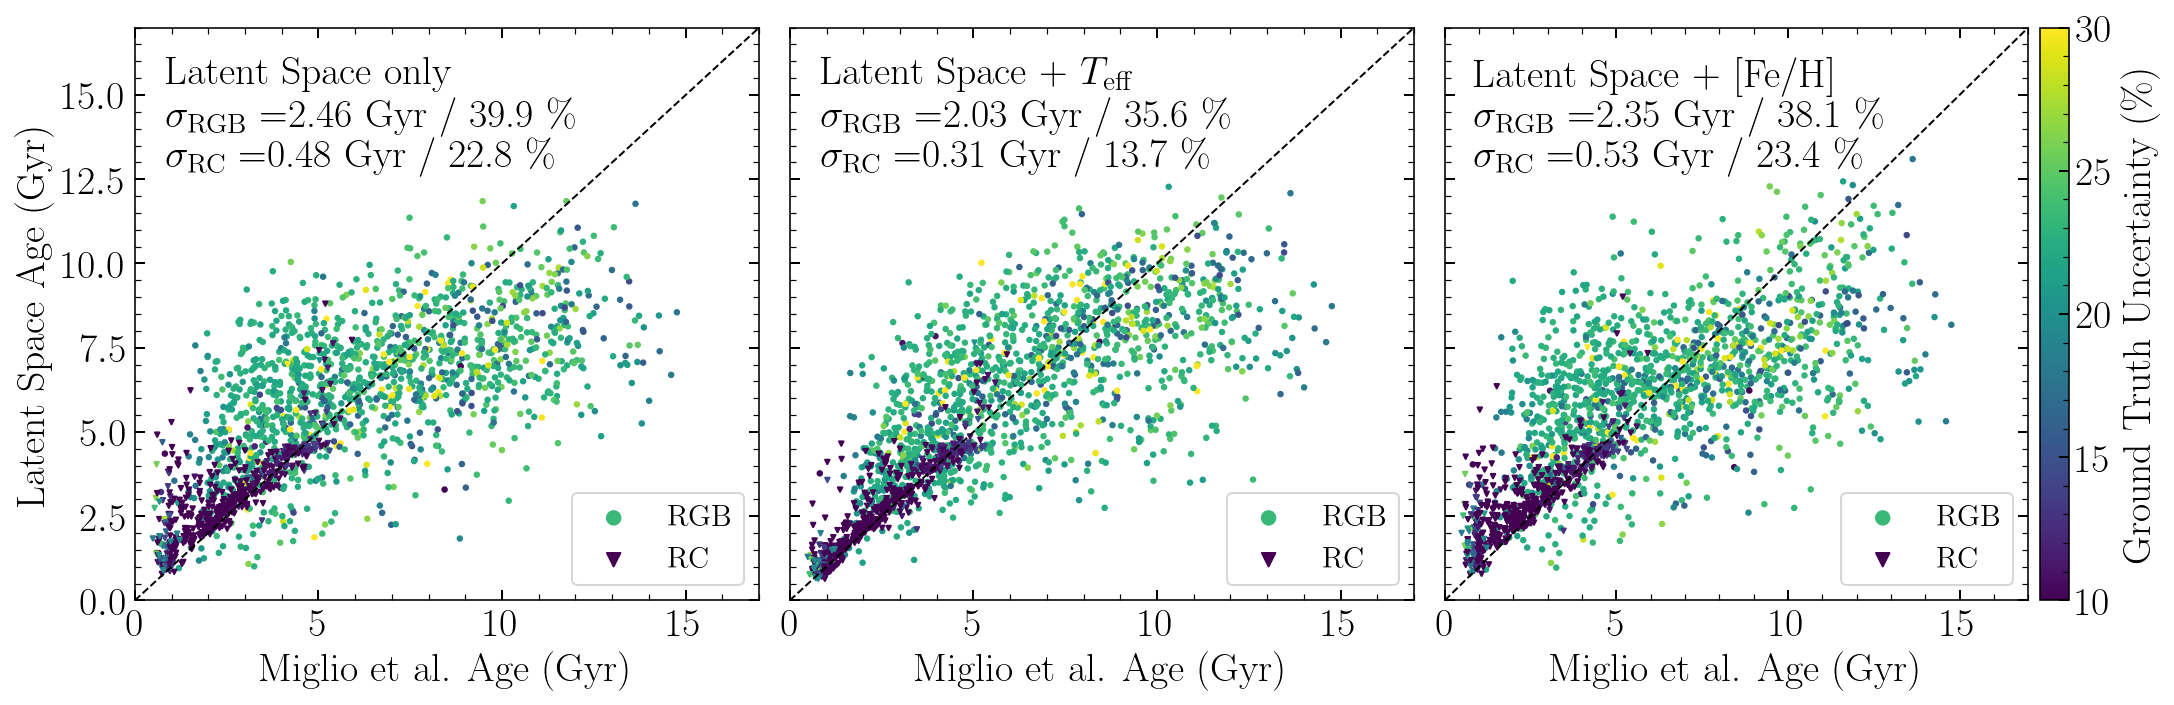

In [3]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from py.ensemble import ProbabilisticRandomForestRegressor

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


def plot(ax, mean, std, text, y_axis=False):
    _regr = ProbabilisticRandomForestRegressor()

    _regr.fit(
        mean[good_idx][good_good_idx],
        np.atleast_2d(apokasc_f.dataset[age_training_name][good_idx][good_good_idx]).T,
        Xerr=std[good_idx][good_good_idx],
        yerr=np.atleast_2d(
            apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx]
        ).T,
        sample_weight=(1.0 / apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx] ** 2)
    )
    
    # bad_good_idx = ((apokasc_f.dataset["APOKASC2_AGE"][bad_idx] > 0.) & (apokasc_f.dataset["APOKASC2_EVSTATES"][bad_idx] == "RGB"))
    bad_good_idx = (apokasc_f.dataset[age_training_name][bad_idx] != -9999.) & (
        apokasc_f.dataset["Evostate"][bad_idx] > 0
    )
    age_pred = 10 ** _regr.predict(mean[bad_idx][bad_good_idx])
    age_pred_stddev = mad_std(age_pred, axis=(-1))
    age_pred = np.mean(age_pred, axis=(-1))
    rgb_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 1
    rc_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 2

    ax.scatter(
        10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rgb_idx],
        age_pred[rgb_idx],
        s=5,
        c=(
            apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
        )[bad_idx][bad_good_idx][rgb_idx]
        * 100,
        vmin=10,
        vmax=30,
        rasterized=True,
        cmap="viridis",
        label="RGB",
    )
    mappable = ax.scatter(
        10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rc_idx],
        age_pred[rc_idx],
        s=5,
        c=(
            apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
        )[bad_idx][bad_good_idx][rc_idx]
        * 100,
        vmin=10,
        vmax=30,
        marker="v",
        rasterized=True,
        cmap="viridis",
        label="RC",
    )
    ax.plot([0.0, 20.0], [0.0, 20], ls="--", c="k")
    ax.set_xlim(0.0, 17.0)
    ax.set_ylim(0.0, 17.0)
    
    ax.text(
        0.05,
        0.95,
        text,
        ha="left",
        va="top",
        fontsize=20,
        transform=ax.transAxes,
    )
    
    ax.text(
        0.05,
        0.88,
        f"$\sigma_{{\mathrm{{RGB}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rgb_idx]):.2f} Gyr /"
        + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rgb_idx])*100:.1f} \%",
        ha="left",
        va="top",
        fontsize=20,
        transform=ax.transAxes,
    )
    ax.text(
        0.05,
        0.81,
        f"$\sigma_{{\mathrm{{RC}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rc_idx]):.2f} Gyr /"
        + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rc_idx])*100:.1f} \%",
        ha="left",
        va="top",
        fontsize=20,
        transform=ax.transAxes,
    )
    ax.legend(loc="lower right")
    ax.set_xlabel("Miglio et al. Age (Gyr)")
    if y_axis:
        ax.set_ylabel("Latent Space Age (Gyr)")
    else:
        ax.yaxis.set_ticklabels([])
    
    return mappable

# ======================================== loop ======================================== #

stacked_z_mean_temp = stack_label(
    stacked_z_mean,
    # apokasc_f.allstar["TEFF"].filled(-9999.0),
    # apokasc_f.allstar["FE_H"].filled(-9999.0),
)

stacked_z_stdev_temp = stack_label(
    z_stdev,
    # apokasc_f.allstar["TEFF_ERR"].filled(-9999.0),
    # apokasc_f.allstar["FE_H_ERR"].filled(-9999.0),
)

plot(ax1, stacked_z_mean_temp, stacked_z_stdev_temp, "Latent Space only", y_axis=True)


stacked_z_mean_temp = stack_label(
    stacked_z_mean,
    apokasc_f.allstar["TEFF"].filled(-9999.0),
    # apokasc_f.allstar["FE_H"].filled(-9999.0),
)

stacked_z_stdev_temp = stack_label(
    z_stdev,
    apokasc_f.allstar["TEFF_ERR"].filled(-9999.0),
    # apokasc_f.allstar["FE_H_ERR"].filled(-9999.0),
)

plot(ax2, stacked_z_mean_temp, stacked_z_stdev_temp, "Latent Space + $T_\mathrm{eff}$")


stacked_z_mean_temp = stack_label(
    stacked_z_mean,
    # apokasc_f.allstar["TEFF"].filled(-9999.0),
    apokasc_f.allstar["FE_H"].filled(-9999.0),
)

stacked_z_stdev_temp = stack_label(
    z_stdev,
    # apokasc_f.allstar["TEFF_ERR"].filled(-9999.0),
    apokasc_f.allstar["FE_H_ERR"].filled(-9999.0),
)

mappable = plot(ax3, stacked_z_mean_temp, stacked_z_stdev_temp, "Latent Space + [Fe/H]")

# ======================================== loop ======================================== #


ax_divider = make_axes_locatable(ax3)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cbar = plt.colorbar(mappable, cax=cax, ticks=[10, 15, 20, 25, 30])
cbar.set_label("Ground Truth Uncertainty (\%)")

fig.tight_layout()
fig.savefig("./figs/age_test_scenario.pdf")

c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Henry\miniconda3\lib\site-packages\astropy\table\column.py:321: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Number of training point:  1245


C:\Users\Henry\AppData\Local\Temp\ipykernel_11704\2669490028.py:59: RuntimeWarning: divide by zero encountered in divide
C:\Users\Henry\AppData\Local\Temp\ipykernel_11704\2669490028.py:73: RuntimeWarning: divide by zero encountered in divide


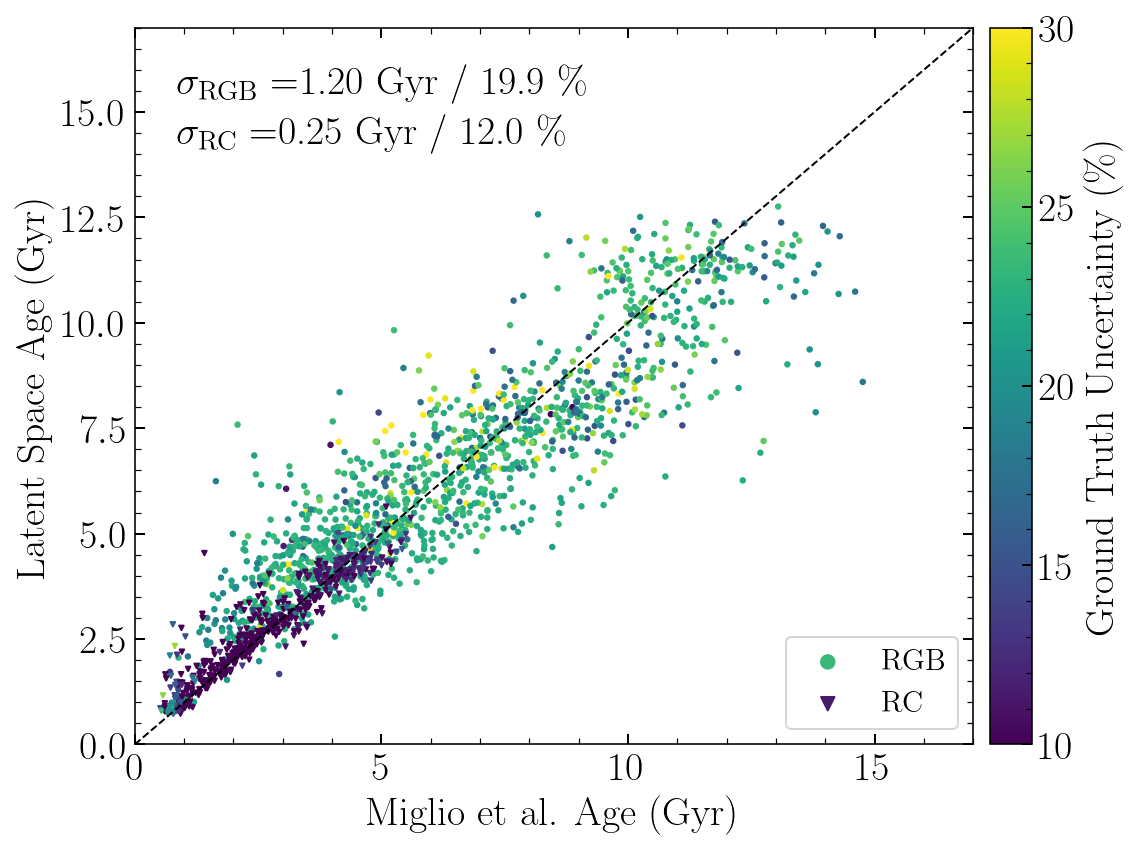

In [14]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from py.ensemble import ProbabilisticRandomForestRegressor

np.random.seed(seed=1)

all_stacked_z_mean = stack_label(
    stacked_z_mean,
    apokasc_f.allstar["TEFF"].filled(-9999.0),
    apokasc_f.allstar["FE_H"].filled(-9999.0),
    apokasc_f.allstar["ALPHA_M"].filled(-9999.0),
)

all_stacked_z_stdev = stack_label(
    z_stdev,
    apokasc_f.allstar["TEFF_ERR"].filled(-9999.0),
    apokasc_f.allstar["FE_H_ERR"].filled(-9999.0),
    apokasc_f.allstar["ALPHA_M_ERR"].filled(-9999.0),
)


age_training_name = "Miglio_LogAge"
good_idx = np.random.choice(list(range(len(z_mean))), size=4000, replace=False)
bad_idx = np.ones(len(z_mean), dtype=bool)
bad_idx[good_idx] = False

regr6_alpha = ProbabilisticRandomForestRegressor()
# good_good_idx = ((apokasc_f.dataset["APOKASC2_AGE"][good_idx] > 0.) & (apokasc_f.dataset["APOKASC2_EVSTATES"][good_idx] == "RGB"))
good_good_idx = (apokasc_f.dataset[age_training_name][good_idx] != -9999.) & (
    apokasc_f.dataset["Evostate"][good_idx] > 0
)
print("Number of training point: ", np.sum(good_good_idx))

regr6_alpha.fit(
    all_stacked_z_mean[good_idx][good_good_idx],
    np.atleast_2d(apokasc_f.dataset[age_training_name][good_idx][good_good_idx]).T,
    Xerr=all_stacked_z_stdev[good_idx][good_good_idx],
    yerr=np.atleast_2d(
        apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx]
    ).T,
    sample_weight=1.0 / apokasc_f.dataset[age_training_name + "_Error"][good_idx][good_good_idx] ** 2
)

# bad_good_idx = ((apokasc_f.dataset["APOKASC2_AGE"][bad_idx] > 0.) & (apokasc_f.dataset["APOKASC2_EVSTATES"][bad_idx] == "RGB"))
bad_good_idx = (apokasc_f.dataset[age_training_name][bad_idx] != -9999.) & (
    apokasc_f.dataset["Evostate"][bad_idx] > 0
)
age_pred = 10 ** regr6_alpha.predict(all_stacked_z_mean[bad_idx][bad_good_idx])
age_pred_stddev = mad_std(age_pred, axis=(-1))
age_pred = np.mean(age_pred, axis=(-1))
rgb_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 1
rc_idx = apokasc_f.dataset["Evostate"][bad_idx][bad_good_idx] == 2

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.scatter(
    10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rgb_idx],
    age_pred[rgb_idx],
    s=5,
    c=(
        apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
    )[bad_idx][bad_good_idx][rgb_idx]
    * 100,
    vmin=10,
    vmax=30,
    cmap="viridis",
    rasterized=True,
    label="RGB",
)
mappable = ax1.scatter(
    10 ** (apokasc_f.dataset[age_training_name])[bad_idx][bad_good_idx][rc_idx],
    age_pred[rc_idx],
    s=5,
    c=(
        apokasc_f.dataset["Miglio_Age_Error"] / 10**apokasc_f.dataset[age_training_name]
    )[bad_idx][bad_good_idx][rc_idx]
    * 100,
    vmin=10,
    vmax=30,
    marker="v",
    cmap="viridis",
    rasterized=True,
    label="RC",
)
ax1.plot([0.0, 20.0], [0.0, 20], ls="--", c="k")
ax1.set_xlim(0.0, 17.0)
ax1.set_ylim(0.0, 17.0)
ax1.text(
    0.05,
    0.95,
    f"$\sigma_{{\mathrm{{RGB}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rgb_idx]):.2f} Gyr /"
    + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rgb_idx])*100:.1f} \%",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.text(
    0.05,
    0.88,
    f"$\sigma_{{\mathrm{{RC}}}}=${mad_std((10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx] - age_pred)[rc_idx]):.2f} Gyr /"
    + f" {mad_std((age_pred / 10**apokasc_f.dataset[age_training_name][bad_idx][bad_good_idx])[rc_idx])*100:.1f} \%",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)
ax1.legend(loc="lower right")
ax1.set_xlabel("Miglio et al. Age (Gyr)")
ax1.set_ylabel("Latent Space Age (Gyr)")

ax_divider = make_axes_locatable(ax1)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cbar = plt.colorbar(mappable, cax=cax, ticks=[10, 15, 20, 25, 30])
cbar.set_label("Ground Truth Uncertainty (\%)")

fig.tight_layout()

In [ ]:
regr6_alpha.save_model("./models/astroNN_VEncoderDecoder/latent_age_model_alphaM")

## Running latent space age model on the whole APOGEE dataset

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from astropy.stats import mad_std
from astroNN.shared import pylab_style
from astroNN.models import load_folder
from py.__init__ import apogee_contspec_path
from astropy.io import fits
from astroNN.apogee import allstar, apogee_astronn
from py.ensemble import ProbabilisticRandomForestRegressor
from py.dataset_utils import stack_label

pylab_style(paper=True)

model = load_folder("./models/astroNN_VEncoderDecoder/")
regr6 = ProbabilisticRandomForestRegressor.load_model("./models/astroNN_VEncoderDecoder/latent_age_model")

contspec = fits.getdata(apogee_contspec_path)
allstar_f = fits.getdata(allstar(dr=17))

good_pred_idx = (
    ~np.isnan(allstar_f["TEFF"])
    & ~np.isnan(allstar_f["FE_H"])
    # we dont need it, but stars without it probably an indicator for bad stars
    & ~np.isnan(allstar_f["ALPHA_M"])
    & (np.sum(contspec, axis=1) != 0.0)
    # & (allstar_f["ASPCAPFLAG"] == 0)
    # & (allstar_f["STARFLAG"] == 0)
    & ((allstar_f["LOGG"] < 3.6) & (allstar_f["LOGG"] > 1.5))
    & (allstar_f["SNREV"] > 30.0)
)
# indices to set bad age back to Nan from good_pred_idx
bad_age_pred_idx = ((allstar_f["LOGG"][good_pred_idx] <= 2.5))

print(np.sum(good_pred_idx))
contspec = contspec[good_pred_idx]
allstar_f = allstar_f[good_pred_idx]

contspec[contspec>2.] = 1.

z_mean_all, _, _ = model.predict_encoder(contspec)
stacked_z_mean = z_mean_all
all_stacked_z_mean = stack_label(z_mean_all, allstar_f["TEFF"], allstar_f["FE_H"])

log_age_pred = regr6.predict(all_stacked_z_mean)
log_age_pred_mean = np.mean(log_age_pred, axis=-1)
log_age_pred_stdev = mad_std(log_age_pred, axis=-1)
age_pred = np.mean(10 ** log_age_pred, axis=-1)
age_pred_stdev = mad_std(10 ** log_age_pred, axis=-1)

# set bad age back to Nan from good_pred_idx
log_age_pred_mean[bad_age_pred_idx] = np.nan 
log_age_pred_stdev[bad_age_pred_idx] = np.nan 
age_pred[bad_age_pred_idx] = np.nan 
age_pred_stdev[bad_age_pred_idx] = np.nan 


# ======== matching to APOGEE DR17 ========
allstar_f = fits.getdata(allstar(dr=17))

apogee_id = allstar_f["APOGEE_ID"]
telescope = allstar_f["TELESCOPE"]
field = allstar_f["FIELD"]
latent = np.ones((len(allstar_f["APOGEE_ID"]), 5)) * np.nan
age_pred_all = np.ones_like(allstar_f["RA"]) * np.nan
age_pred_stdev_all = np.ones_like(allstar_f["RA"]) * np.nan
log_age_pred_all = np.ones_like(allstar_f["RA"]) * np.nan
log_age_pred_stdev_all = np.ones_like(allstar_f["RA"]) * np.nan

latent[good_pred_idx] = z_mean_all
age_pred_all[good_pred_idx] = age_pred
age_pred_stdev_all[good_pred_idx] = age_pred_stdev
log_age_pred_all[good_pred_idx] = log_age_pred_mean
log_age_pred_stdev_all[good_pred_idx] = log_age_pred_stdev

Loaded astroNN model, model type: Convolutional Variational Autoencoder -> ApokascEncoderDecoder
50093
Starting Inference on Encoder
2/2 [==============================] - 0s 47ms/step
Completed Inference on Encoder, 3.80s elapsed


In [2]:
# generate catalog
import pandas as pd

allstar_f = fits.getdata(allstar(dr=17))

apogee_id = allstar_f["APOGEE_ID"]
telescope = allstar_f["TELESCOPE"]
field = allstar_f["FIELD"]
starflag = allstar_f["STARFLAG"]
aspcapflag = allstar_f["ASPCAPFLAG"]
latent = np.ones((len(allstar_f["APOGEE_ID"]), 5)) * np.nan
age_pred_all = np.ones_like(allstar_f["RA"]) * np.nan
age_pred_stdev_all = np.ones_like(allstar_f["RA"]) * np.nan
log_age_pred_all = np.ones_like(allstar_f["RA"]) * np.nan
log_age_pred_stdev_all = np.ones_like(allstar_f["RA"]) * np.nan

latent[good_pred_idx] = z_mean_all
age_pred_all[good_pred_idx] = age_pred
age_pred_stdev_all[good_pred_idx] = age_pred_stdev
log_age_pred_all[good_pred_idx] = log_age_pred_mean
log_age_pred_stdev_all[good_pred_idx] = log_age_pred_stdev

pd.DataFrame({"APOGEE_ID": apogee_id, 
              "TELESCOPE": telescope, 
              "FIELD": field, 
              "STARFLAG": starflag, 
              "ASPCAPFLAG": aspcapflag, 
              "z0": latent[:, 0], 
              "z1": latent[:, 1], 
              "z2": latent[:, 2], 
              "z3": latent[:, 3], 
              "z4": latent[:, 4], 
              "Age": age_pred_all, 
              "Age_Error": age_pred_stdev_all, 
              "LogAge": log_age_pred_all, 
              "LogAge_Error": log_age_pred_stdev_all}).to_csv("nn_latent_age_dr17.csv.gz", index=False, compression="gzip")

47523


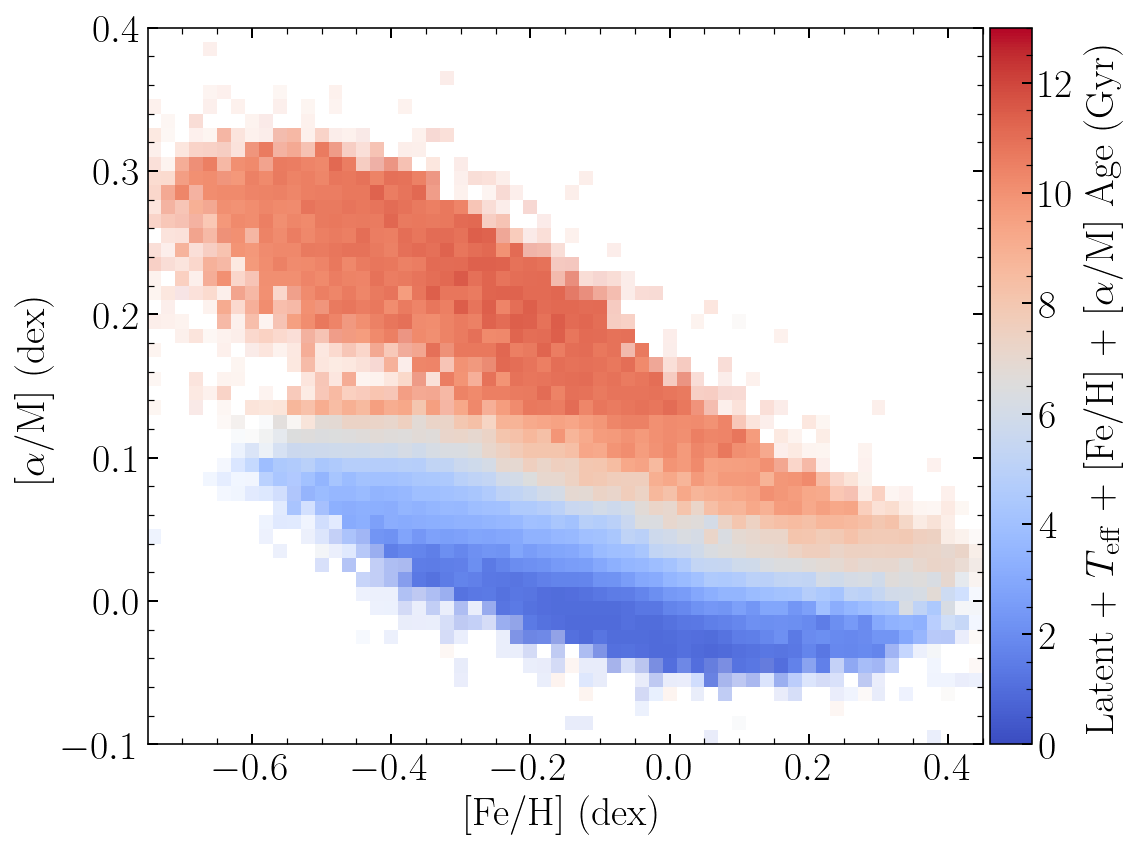

In [3]:
from py.plot_utils import plot_alpha_age

good_idx = (age_pred_stdev_all / age_pred_all < 0.5)
print(np.sum(good_idx))
alpha = allstar_f["ALPHA_M"][good_idx]
fe_h = allstar_f["FE_H"][good_idx]
age = age_pred_all[good_idx]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
plot_alpha_age(ax1, fe_h, alpha, age, range=((-0.75, 0.45), (-0.1, 0.4)), bins=[60, 50], cbar_label=r"Latent + $T_\mathrm{eff}$ + [Fe/H] + [$\alpha$/M] Age (Gyr)")

fig.tight_layout()
fig.savefig("./figs/feh_all_you_can_alpha.pdf")

In [2]:
def random_forest_latent(features_importances, latent_dims, other_label_names):
    latent_sum = np.sum(features_importances[:latent_dims])
    print("Random Forest feature importances:")
    print(f"Latent: {latent_sum:.3f}")
    for idx, i in enumerate(other_label_names):
        print(f"{i}: {features_importances[idx+latent_dims]:.3f}")
        
random_forest_latent(regr6.feature_importances_, 5, ["Teff", "Fe_H"])

Random Forest feature importances:
Latent: 0.261
Teff: 0.604
Fe_H: 0.135


## Inspect the dataset

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from astropy.stats import mad_std
from astroNN.shared import pylab_style
from astropy.io import fits
from astroNN.apogee import allstar, apogee_astronn

pylab_style(paper=True)

allstar_f = fits.getdata(allstar(dr=17))
ls_age = pd.read_csv("./nn_latent_age_dr17.csv.gz")

age_pred_all = ls_age["Age"]
age_pred_stdev_all = ls_age["Age_Error"]
starflag = ls_age["STARFLAG"]
aspcapflag = ls_age["ASPCAPFLAG"]


56258


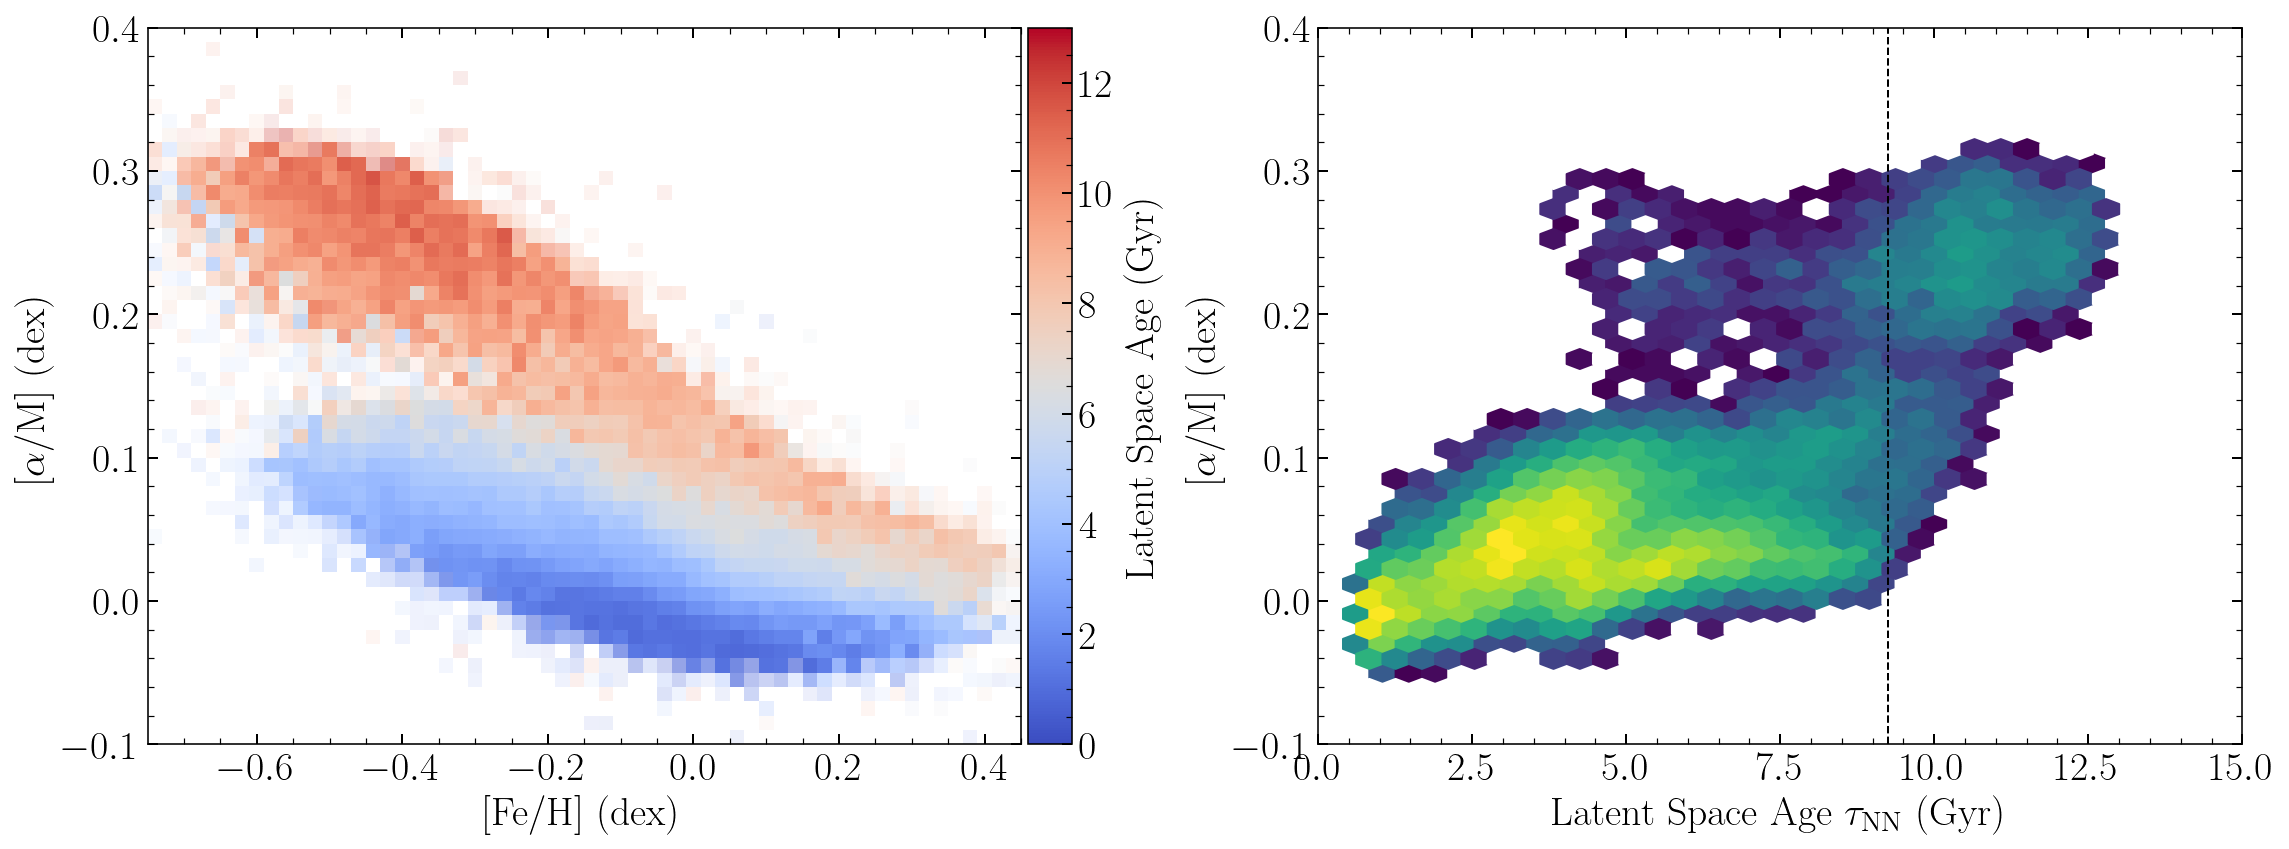

In [12]:
import copy
from py.plot_utils import plot_alpha_age

good_idx = (age_pred_stdev_all / age_pred_all < 0.5) & (starflag == 0) & (aspcapflag == 0)
print(np.sum(good_idx))
alpha = allstar_f["ALPHA_M"][good_idx]
fe_h = allstar_f["FE_H"][good_idx]
age = age_pred_all[good_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_alpha_age(ax1, fe_h, alpha, age, range=((-0.75, 0.45), (-0.1, 0.4)), bins=[60, 50], cbar_label="Latent Space Age (Gyr)")

custom_cmap = copy.copy(plt.get_cmap('viridis'))
custom_cmap.set_under(color='white')

ax2.hexbin(age, alpha, bins="log", vmin=10, gridsize=[30, 30], cmap=custom_cmap)
ax2.set_ylabel(r"[$\alpha$/M] (dex)")
ax2.set_xlim(0, 15)
ax2.set_ylim(-0.1, 0.4)
ax2.set_xlabel("Latent Space Age $\\tau_\mathrm{NN}$ (Gyr)")
ax2.axvline(9.25, c="k", ls="--", lw=1)
fig.tight_layout()
fig.savefig("./figs/feh_alpha_age.pdf")

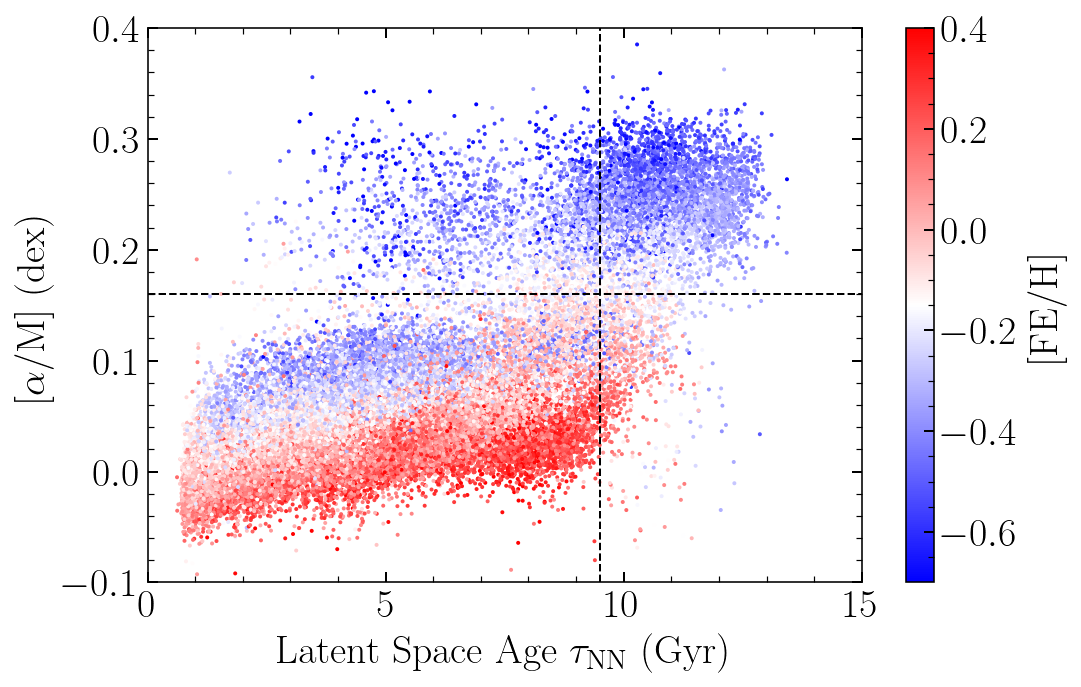

In [22]:
fig, ax1 = plt.subplots(1, 1)
ax1.scatter(age, alpha, c=fe_h, s=1, cmap="bwr", vmin=-0.7, vmax=0.4)
ax1.set_ylabel(r"[$\alpha$/M] (dex)")
ax1.set_xlim(0, 15)
ax1.set_ylim(-0.1, 0.4)
ax1.set_xlabel("Latent Space Age $\\tau_\mathrm{NN}$ (Gyr)")
ax1.axvline(9.5, c="k", ls="--", lw=1)
ax1.axhline(0.16, c="k", ls="--", lw=1)
cbar = plt.colorbar(mappable, ax=ax1)
cbar.set_label("[FE/H]")

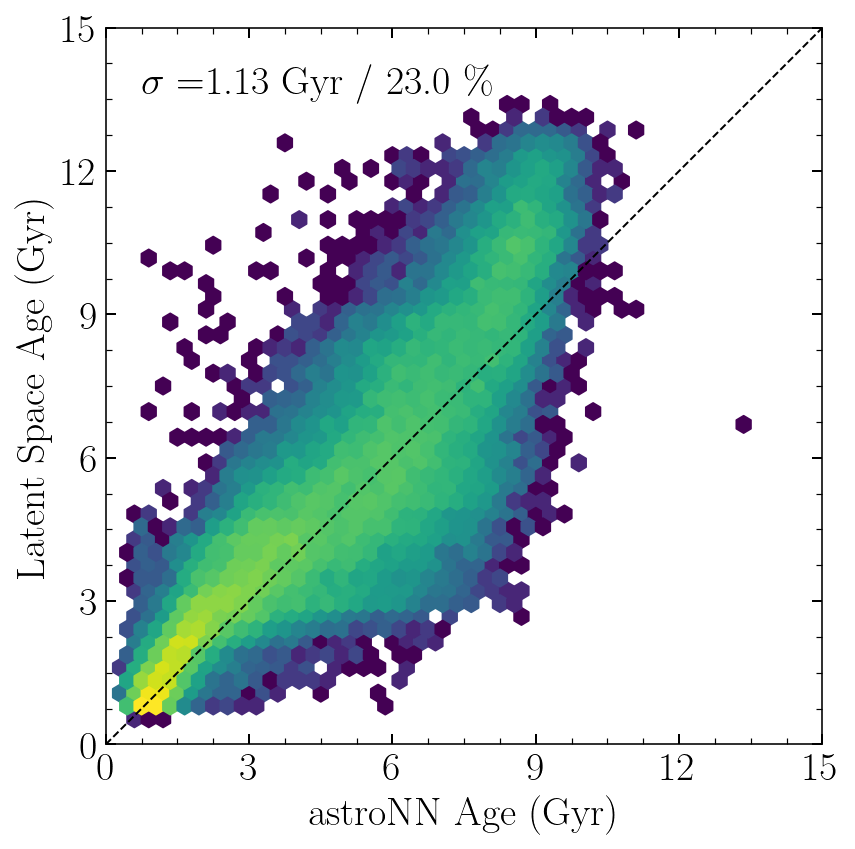

In [9]:
astronn_f = fits.getdata(apogee_astronn(dr=17))

fig, ax1 = plt.subplots(1, 1, figsize=(6.2, 6))
ax1.hexbin(astronn_f["age"][good_idx], age, bins="log", extent=(0, 15, 0, 15), gridsize=50, rasterized=True)
ax1.plot([0, 15], [0, 15], ls="--", c="k")

ax1.text(
    0.05,
    0.95,
    f"$\sigma=${mad_std(astronn_f['age'][good_idx]- age, ignore_nan=True):.2f} Gyr / {mad_std((astronn_f['age'][good_idx]- age) / age, ignore_nan=True)*100:.1f} \%",
    ha="left",
    va="top",
    fontsize=20,
    transform=ax1.transAxes,
)

ax1.set_xlim(0, 15)
ax1.set_ylim(0, 15)
ax1.get_xaxis().set_ticks([0, 3, 6, 9, 12, 15])
ax1.get_xaxis().set_ticklabels([0, 3, 6, 9, 12, 15])
ax1.get_yaxis().set_ticks([0, 3, 6, 9, 12, 15])
ax1.get_yaxis().set_ticklabels([0, 3, 6, 9, 12, 15])
ax1.set_xlabel("astroNN Age (Gyr)")
ax1.set_ylabel("Latent Space Age (Gyr)")
ax1.set_aspect("equal")
fig.tight_layout()
fig.savefig("./figs/astroNN_vs_latentspace.pdf")